In [1]:
import numpy as np
from time import time
from lloyd import update_lloyd
from utils import calc_sq_distances
from kernels import build_kernel_matrix
from quality import calc_silhouettes
from elkan import update_elkan, start_elkan

In [26]:
class KKMeans():
    '''
    Kernel K-Means Clustering.

    Read more in the thesis. TODO
    Designed to mimic sklearn.cluster.KMeans
    limitations: kernel matrix

    Parameters 
    ----------

    n_clusters: int, default=8
        The number of clusters to form.

    init: {kmeans++, random, truerandom} or arraylike, default = kmeans++
        Initialization method. 
        kmeans++: heuristic to choose "good" starting centers
            For more, see: thesis or
            Arthur and Vassilvitskii, Kmeans++ the 
            advantage of carefull seeding, 2007
        random: Randomly takes existing datapoints as centers
        truerandom: assigns random labels to each datapoint
        
        If arraylike is passed, its content are used as centers

    n_init: int, default=3 
        The number of clusterings computed. As KKMeans is 
        a heuristic that converges to local optima, 
        mutliple runs are beneficial. 
    
    max_iter: int, default=300
        Maximal amount of iterations for each run.
    
    tol: float, default = 0.0004
        Max difference of quality-metric between iterations
        to declare run for converged.
        If 0., run converges only when labels do not change
        or max_iter is reached.
    
    q_metrics: {inertia, silhouette}, default=inertia
        Quality metric by which each clustering is measured.

        inertia:  also called variance, sum of squared distances 
            from each point to its assigned center. Objective function in 
            (Kernel) K-means. 

        silhouette: Measures how "ambiguous" the assignment of a point
            to its cluster is; if the loss function would not change
            if it were assigned to the next best cluster, the silhouette 
            of said point would be 0.
            -1 <= silhouette <= 1
            For elkan, this does not work as elkan does not calculate
            the distance to every cluster centers.
            calculated via:
            a(x) = d(x, centers[x])
            b(x) = min_y(d(x, centers[y])) where y != x
            silhouette(x) = (b(x) - a(x))/max{a(x), b(x)}
            This is then averaged for every point.  
    
    verbose: bool, default=False
    
    rng: int, default=None
        Seed which will be passed to np.random.defaul_rng
        to create random generator.
        When none, "fresh, unpredictable entropy will be pulled from the OS"
            - np random generator docpage.
    
    algorithm: {"lloyd", "elkan"}, default=elkan
        The algorithm which will be used for commputation.
        lloyd is the standard heuristic used to solve the k-means   
        problem. This is a simplified version of Elkan's algorithm
        that does not need to calculate pairwise cluster distances.
        The original elkan (wiht pw cluster distances) is slower
        than lloyd's when utilizing a kernel matrix.

    kernel: {"linear", "rbf", "polynomial", "sigmoid", "gaussian"}, default="linear"
        Which kernel shall be used to compute the kernel matrix.
        Gaussian is equal to rbf with gamma = variance**-2
        Linear calculates a regular kmeans clustering.

    **kwargs: 
        Arguments which are passed to the kernel function.
        Dependant on kernel used

    Attributes
    ----------

    labels_: ndarray of shape (n_samples)
        labels of each point
    
    inner_sums_: ndarray of shape (n_clusters)
        Mathematical term used for prediction, stored
        to avoid recomputing/storing full kernel matrix.
        =SUM(K(x, x')) -> for each x, x' in cluster C
            -> for each cluster C
    
    cluster_sizes_: ndarray of shape(n_clusters)
        amount of points in each clusters
    
    X_: ndarray of shape(n_samples, n_features)
        The data which was passed to be clustered.

    quality_: float
        Quality measured by the passed q_metric.
        If tol=0 only gets measured at the end of a "run".


    Methods
    -------
    kernel_wrapper()

    TODO
    '''
    def __init__(self, n_clusters=8, init="kmeans++", n_init=3,
                 max_iter=300, tol=1e-4, q_metric="inertia", verbose=False,
                 rng=None, algorithm="elkan", kernel="linear", **kwargs):
        '''
        Ctor for KKMeans, more details in class docstring. 
        Calls validation function after initializing the class parameters,
        which can raise exceptions.
        
        n_clusters: int, default=8
        init: {"kmeans++", "random", "truerandom"}, default = "kmeans++"
        n_init: int, default=3
        max_iter: int, default=300
        tol: float, default=0.0004
        q_metric: {inertia, silhouette}, default="inertia"
        verbose: bool, default=True
        rng: int, default=None
        algorithm: {"lloyd", "elkan"}, default="elkan"
        kernel: {"linear", "rbf", "polynomial", "sigmoid", "gaussian"}, default="linear"

        '''
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.q_metric = q_metric
        self.verbose = verbose
        self.rng = np.random.default_rng(rng)
        self.algorithm = algorithm
        self.kernel = kernel
        self.kwargs = kwargs

        self._validate_params()

        # Class attributes that are used for information storage

        self.labels_ = None
        self.inner_sums_ = None
        self.cluster_sizes_ = None
        self.X_ = None
        self.quality_ = None
    

    def _validate_params(self):
        '''Checks for possible errors in the parameters, can raise exceptions'''
        if self.algorithm == "elkan" and self.q_metric == "silhouette":
            print("WARNING: using silhouette with elkan will most likely be inaccurate\
                  as elkan does not calculate exact distances to every center")
        if self.n_init <= 0:
            raise ValueError("n_inits needs to be at least 1")
        if self.algorithm not in ("lloyd", "elkan"):
            raise NotImplementedError(str(self.algorithm)+ " not implemented")
        if self.init not in ("kmeans++", "random", "truerandom"):
            raise NotImplementedError("Quality metric not implemented")
        if self.q_metric not in ("silhouette, inertia"):
            raise NotImplementedError("Quality metric not implemented")

    def kernel_wrapper(self, X, Y=None):
        '''
        Wrapper function to compute kernel matrix
        
        If Y is None, Kernel is computed pairwise KM[i,j] = k(X[i], X[j])
        If Y is not None, KM[i,j] = k(X[i], Y[j])

        Parameters
        ----------
        X: arraylike of shape(*, n_features)
        Y: arraylike of shape(*, n_features) or None, default=None

        Returns
        -------
        Kernel Matrix, either of shape(len(X), len(X))
            or (len(X), len(Y))
        '''
        return build_kernel_matrix(X, Y, kernel=self.kernel, **self.kwargs)

    def fit(self, X):
        '''
        Fits the data X with the given parameters.

        Executes self.n_inits runs of self.algorithm,
        utlizing self.q_metric with self.tol to check for convergence.
        Safes the results in class attributes.

        Parameters
        ----------
        X: arraylike of shape(n_samples, n_features)
            The data which should be fit.
        '''
        X = np.ascontiguousarray(X, dtype=np.double)
        X = self._validate_data(X)
        kernel_matrix = self.kernel_wrapper(X)
        
        #Storage for each attribute to be safed per iteration
        labels_store = np.zeros((self.n_init, X.shape[0]), dtype=np.int_)
        quality_store = np.zeros(self.n_init, dtype=np.double)
        inner_sums_store = np.zeros((self.n_init, self.n_clusters), dtype=np.double)
        sizes_store = np.zeros((self.n_init, self.n_clusters), dtype=np.int_)
        
        for init in range(self.n_init):
            start_labels = self._init_labels(X, kernel_matrix)
            if self.algorithm == "lloyd":
                labels, quality, inner_sums, sizes = self.lloyd(kernel_matrix, start_labels)
            elif self.algorithm == "elkan":
                labels, quality, inner_sums, sizes = self.elkan(kernel_matrix, start_labels)
            else:
                raise ValueError(str(self.algorithm) + " algorithm not implemented; \
                                 this should have been caught in _check_params")
            labels_store[init] = labels
            quality_store[init] = quality
            inner_sums_store[init] = inner_sums
            sizes_store[init] = sizes

        best_init = self._get_best_init(quality_store)
        self.labels_ = labels_store[best_init]
        self.inner_sums_ = inner_sums_store[best_init]
        self.cluster_sizes_ = sizes_store[best_init]
        self.quality_ = quality_store[best_init]
        self.X_ = X
        
        self._out_finish(best_init)

    def _get_best_init(self, quality_store):
        """Returns best quality score given self.q_metric"""
        if self.q_metric == "inertia": # smalles is better
            return np.argmin(quality_store) 
        elif self.q_metric == "silhouette": # bigger is better
            return np.argmax(quality_store) 
        else:
            raise NotImplementedError(str(self.q_metric) + 
                                      " metric not implemented; \
                                      this should have been caught in _check_params")

    def _out_finish(self, best_init):
        '''output at the end of self.fit'''
        print("Best " + self.q_metric +":", self.quality_,
              "Found at init:", best_init + 1)

    def _validate_data(self, X):
        """checks for invalidate data, can raise exceptions."""
        X = np.asarray(X, dtype=np.double)
        if len(X.shape) != 2:
            raise ValueError("X needs to be 2-d Array")
        if 0 in X.shape:
            raise ValueError("X is empty")
        if X.shape[0] <  self.n_clusters:
            raise ValueError("sample:cluster ratio needs to be at least one")
        return X
    
    def _init_labels(self, X, kernel_matrix):
        '''Assign labels to each datapoint by given method'''

        # hasattr(x, __iter__) to check if object may be arraylike 
        if hasattr(self.init, "__iter__") and not isinstance(self.init, str): 
            centers = np.asarray(self.init, dtype=np.double)
            self.init = self._validate_centers(centers) 
            return self._assign_to_centers(X, self.init)
        
        elif self.init == "random":
            centers = self.rng.choice(X, self.n_clusters)
            return self._assign_to_centers(X, centers)
        
        elif self.init == "truerandom":
            return self.rng.integers(0, self.n_clusters, len(X), dtype=np.int_)
        
        elif self.init == "kmeans++":
            return self.kmeanspp(X, kernel_matrix)
        
        raise NotImplementedError("Unknown initialisation method")
    
    def _validate_centers(self, centers):
        '''checks for invalid centers, can raise exceptions.'''
        if not isinstance(centers, np.ndarray):
            raise ValueError("Given centers must be ndarray")   
        if centers.ndim != 2:
            raise ValueError("Given centers need to be 2-d array")
        if 0 in centers.shape:
            raise ValueError("Given centers are empty")
        if centers.shape[0] != self.n_clusters:
            raise ValueError("Amount of given centers must be equal to n_clusters")
        return centers
        
    def _assign_to_centers(self, X, centers):
        '''
        Assigns each datapoint to the closest given center.

        Distance is calculated via Kernel trick.
        In feature space, d(x, c) is calculated via:
        sqrt(K(x, x) - 2K(x, c) + K(c,c)), K being
        the kernel function.
        As 0 <= sqrt(x) < sqrt(y) => x < y the sqrt needs not be
        taken.
        Also, as K(x,x) is constant for each x it can be omitted. 

        Parameters
        ----------
        X: ndarray of shape(n_samples, n_clusters)
            data which should be assigned labels
        centers: ndarray of shape(n_clusters)
        
        Returns
        -------

        labels: ndarray of shape(n_samples)
            labels[i] == cluster X[i] is assigned to 
        '''
        X_center_kernel = self.kernel_wrapper(X, centers)
        dists_to_centers = np.zeros((len(X), self.n_clusters)) 
        for cluster in range(self.n_clusters):
            dists_to_centers[:, cluster] = (-2 * X_center_kernel[:, cluster]
                                         + self.kernel_wrapper(centers[cluster]))
        return np.asarray(np.argmin(dists_to_centers, axis=1), dtype=np.int_)

    def kmeanspp(self, X, kernel_matrix):
        '''
        Computes heuristic to get good initial centers

        If used externally, KKMeans instance has to be initialized
        properly (kernel, kwargs, n_clusters)
        Kmeans++:
            1. choose first center at random
            2. choose x as next center with probability of
                the normalized squared distance to its next 
                cluster center
            3. repeat 2 until k centers are found.
        Here, K(x,x) must not be omitted like in _assign_to_centers
        as the probabilities get normalized over the whole dataset.
        Returns labels and not centers as distances need to be computed 
        here anyhow.

        Parameters
        ----------
        X: ndarray of shape(n_samples, n_clusters)
            data which should be assigned labels.
            used to grab existing datapoints
        kernel_matrx: ndarray of shape(n_samples, n_samples)
            kernel matrix of X

        Returns
        -------
        ndarray of shape(n_samples)
            Labels for each datapoint
        '''
        #those will be square dists
        dists_to_centers = self._build_starting_distance(kernel_matrix)
        n_samples = X.shape[0]
        for cluster in range(self.n_clusters):
            if cluster == 0:
                # choose first center randomly
                index = self.rng.integers(low=0, high=n_samples)
            else:
                # careful, dists_to_centers not initialized with 0
                max_dist_each = np.amin(dists_to_centers[:, :cluster + 1], axis = 1)
                probs = max_dist_each/max_dist_each.sum()
                index = self.rng.choice(n_samples, size=1, p=probs)
            center = X[index]
            inner_sum = self.kernel_wrapper(center)
            outer_sum = self.kernel_wrapper(X, center)
            # reshape necessary as kernel_wrapper has 2dim array output
            dists_to_centers[:, cluster] += (-2 * outer_sum + inner_sum).reshape(n_samples,)
             
        return np.asarray(np.argmin(dists_to_centers, axis=1), dtype=np.int_)

    def lloyd(self, kernel_matrix, labels):
        '''
        Computes a run of lloyd's algorithm

        Distances are actually sqared distances, as this is kmeans 
        objective function.
        As mentionend before, inner_sums and cluster_sizes 
        are computed anyways and are stored to safe time when 
        predicting.
        Utilizes cython-written update_lloyd function to do
        the heavy lifting.
        More details in update_lloyd

        Parameters
        ----------
        kernel_matrix: ndarray of shape(n_samples, n_samples)
            kernel matrix of the data to fit
        labels: ndarray of shape(n_samples)
            starting labels

        Returns:
            labels: ndarray of shape(n_samples)
                labels for each datapoint
            quality: float
                final quality score.
            inner_sums:
                mathematical term to ease prediction
                more info in class docstring
            cluster_sizes:
                size of each cluster
                returned to ease prediction
        '''
        # Init with value so that first iteration cannot converge because
        # quality does not change.
        quality = np.NINF
        for it in range(self.max_iter):
            distances = self._build_starting_distance(kernel_matrix)
            distances, inner_sums, cluster_sizes = update_lloyd(distances, kernel_matrix, 
                                                                labels, self.n_clusters)
            labels_old = labels
            labels = np.asarray(np.argmin(distances, axis=1), dtype=np.int_)
            
            quality, converged = self._measure_iter(distances, labels, labels_old, quality)
            self._out_verbose(it, quality, converged=converged)
            if converged:
                break
        
        return labels, quality, inner_sums, cluster_sizes
    


    def _out_verbose(self, iter, quality, converged):
        '''Checks if self.verbose and prints accordingly'''
        if not self.verbose:
            return
        if converged:
            print("Converged at iteration:", iter + 1, self.q_metric + ":", quality)
        elif self.tol == 0:
            print("Iteration:", iter + 1, self.q_metric + ":", "Not calculated (Tol==0)")
        else:
            print("Iteration:", iter + 1, self.q_metric + ":", quality)
    
    def predict(self, X):
        '''
        Computes the closest cluster center for each x in X

        squared distance from datapoint x to center c:
            K(x,x) - 2K(x,c) + K(c,c)

        As sqrt is monotonic, 
            0 < x < y => 0 < sqrt(x) < sqrt(y)
        and therefore sqrt needs not be taken.
        As K(x,x) is constant for each x it does not
        influence the assignment and can consequently 
        be omitted.

        Parameters
        ----------
        X: ndarray
            the data which should be predicted
        
        Returns
        -------
        ndarray of shape(n_samples)
            labels for each datapoint in X
        '''
        #TODO TEST
        if self.X_ is None:
            raise ValueError("KKMeans instance is not fitted!")
        kernel_matrix = self.kernel_wrapper(X, self.X_)
        sq_distances = calc_sq_distances(
            self.inner_sums_, self.cluster_sizes_,
            kernel_matrix, self.labels_, 
            self.n_clusters)
        return np.argmin(sq_distances, axis=1)
    
    def _measure_iter(self, sq_distances, labels, labels_old, quality):
        '''
        Measures quality of iteration and checks for convergence

        If self.tol == 0 skips quality calculation except when labels did 
        not change to previous iteration, as then algorithm is finished.
        criteria for convergence are:
            abs(quality - quality_old) <=self.tol
            or all(labels == labels_old)
        
        Parameters
        ----------
        sq_distances: ndarray of shape(n_samples, n_clusters)
            squared distances from each sample to each cluster
        labels: ndarray of shape(n_samples)
            new labels for each sample
        labels_old: ndarray of shape(n_samples)
            labels from the previous iteration
        quality: float
            quality from the previous iteration
        
        Returns
        -------
        quality: float
            quality of current iteration
        converged: bool
            is the algorithm converged?
        '''
        converged = False
        if self.tol != 0:
            quality_old = quality
            quality = self.calc_q_metric(sq_distances, labels)
            if abs(quality - quality_old) <= self.tol:
                converged = True

        if all(labels_old == labels):
            if self.tol == 0:
                quality = self.calc_q_metric(sq_distances, labels)
            converged = True
        
        return quality, converged

    def calc_q_metric(self, sq_distances, labels):
        '''
        Calculates quality metric

        inertia is the sum of squared distances from each datapoint to
        its assigned center.
        silhouette is a heuristic that describes how significant the assignment
        of a point to its cluster is. Yields a value between -1 and 1.
        As elkan only guarantees to calculate the distances to the closest
        cluster center correctly, it is discouraged to measure it with 
        silhouette.

        Parameters
        ----------
        sq_distances: ndarray of shape(n_samples, n_features)
            square distances between points and centers
        labels: ndarray of shape(n_samples)
            labels for each datapoint

        Returns
        -------
        float, the calculated quality score
        '''
        if self.q_metric == "inertia":
            return sq_distances[range(sq_distances.shape[0]), labels].sum()
        elif self.q_metric == "silhouette":
            return self.calc_silhouette(sq_distances, labels)
        else:
            raise NotImplementedError(str(self.q_metric) + " quality metric not implemented")
            
    def calc_silhouette(self, sq_distances, labels):
        '''Calculates average silhouette of clustering
        
        sq_distances need to be exact for the two closest 
        centers for each datapoint (elkan does not provide this).
        Computes silhouette for every datapoint and averages it.
        
        Parameters
        ----------
        sq_distances: ndarray of shape(n_samples, n_clusters)
            squared distances from points to centers
        labels: ndarray of shape(n_samples)

        Returns
        -------
        Average silhouette of each datapoint
        '''
        silhouettes = calc_silhouettes(sq_distances, labels)
        return sum(silhouettes) / len(silhouettes)
    
    def _build_starting_distance(self, kernel_matrix):
        '''
        Builds basis for computing square distances

        K(x, x),  K(x, x),  ....    K(x, x)
        K(x',x'), K(x',x'), ....    K(x',x')
        ...       ...       ....    ...
        ....
        '''
        # np.diag(kernel_matrix) returns [K(x,x), K(x', x'),...]
        # rest is for stacking correctly
        # ascontiguousarray is necessary as by transposing ndarray becomes f-ordered
        # c-order is necessary for cython.
        return np.ascontiguousarray(np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T, dtype=np.double)

    def elkan(self, kernel_matrix, labels):
        '''
        Computes a slightly optimized Kernel-Kmeans heuristic

        This is _not_ the original elkan, but it is founded on
        the same observation regarding the triangle equality.
        Keeps record of how much centers have moved since the last
        exact computation of distance and only calculates distance 
        to a center if it is possible to have moved closer than the 
        currently assigned center.
        Relative speedup increases with n_clusters.

        Parameters
        ----------
        kernel_matrix: ndarray of shape(n_samples, n_samples)
        labels: ndarray of shape(n_samples)
            starting labels

        Returns:
            labels: ndarray of shape(n_samples)
            quality: float
            inner_sums:
                mathematical term to ease prediction
                more info in class docstring
            cluster_sizes:
                size of each cluster
                returned to ease prediction
        '''
        labels = np.array(labels, dtype=np.int_) # TODO delete and change dtype in init_labels
        start_dists = self._build_starting_distance(kernel_matrix)
        center_dists = np.zeros((kernel_matrix.shape[0], self.n_clusters))
        quality = 0
        for it in range(self.max_iter):
            if it == 0:
                l_bounds, inner_sums, sizes = start_elkan(
                    start_dists, kernel_matrix, labels, 
                    self.n_clusters)
            else:
                l_bounds, inner_sums, sizes, center_dists = update_elkan(
                    kernel_matrix, l_bounds, center_dists, 
                    labels, labels_old, sizes, inner_sums, 
                    self.n_clusters)

            labels_old = labels
            labels = np.array(np.argmin(l_bounds, axis=1), dtype=np.int_)
            
            quality, converged = self._measure_iter(l_bounds, labels, labels_old, quality)
            self._out_verbose(it, quality, converged=converged)
            if converged:
                break

        return labels, quality, inner_sums, sizes


In [27]:
help(KKMeans)

Help on class KKMeans in module __main__:

class KKMeans(builtins.object)
 |  KKMeans(n_clusters=8, init='kmeans++', n_init=3, max_iter=300, tol=0.0001, q_metric='inertia', verbose=False, rng=None, algorithm='elkan', kernel='linear', **kwargs)
 |  
 |  Kernel K-Means Clustering.
 |  
 |  Read more in the thesis. TODO
 |  Designed to mimic sklearn.cluster.KMeans
 |  limitations: kernel matrix
 |  
 |  Parameters 
 |  ----------
 |  
 |  n_clusters: int, default=8
 |      The number of clusters to form.
 |  
 |  init: {kmeans++, random, truerandom} or arraylike, default = kmeans++
 |      Initialization method. 
 |      kmeans++: heuristic to choose "good" starting centers
 |          For more, see: thesis or
 |          Arthur and Vassilvitskii, Kmeans++ the 
 |          advantage of carefull seeding, 2007
 |      random: Randomly takes existing datapoints as centers
 |      truerandom: assigns random labels to each datapoint
 |      
 |      If arraylike is passed, its content are used

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

In [18]:
def visualize(data, labels):
    if len(data[0]) > 3:
        raise Exception("Dimensionality is too high for visualization")
    elif len(data[0]) == 1:
        plt.scatter(data, [0 for x in range(len(data))], c = labels)
    elif len(data[0]) == 2:
        plt.scatter(data[:,0], data[:,1], c = labels)
    elif len(data[0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection = "3d")
        ax.scatter(data[:,0], data[:,1], data[:,2], c = labels)

In [19]:
x, labels, centers = make_blobs(10000, centers=100, return_centers = True, random_state = 0, n_features = 5)

In [22]:
kkm = KKMeans(n_clusters=100, init = "kmeans++", n_init=1, max_iter=100, algorithm="elkan", verbose=True, rng=0)

In [23]:
kkm.fit(x)

Iteration: 1 inertia: 75828.41860903654
Iteration: 2 inertia: 70519.83963297532
Iteration: 3 inertia: 66709.37705373052
Iteration: 4 inertia: 65250.91360224334
Iteration: 5 inertia: 64408.82671054584
Iteration: 6 inertia: 64153.121865497
Iteration: 7 inertia: 64050.82466927332
Iteration: 8 inertia: 63835.6719711461
Iteration: 9 inertia: 63388.79203203095
Iteration: 10 inertia: 62660.74191973537
Iteration: 11 inertia: 62400.86819366465
Iteration: 12 inertia: 62397.41115617266
Iteration: 13 inertia: 62394.366217674644
Iteration: 14 inertia: 62392.571791106566
Iteration: 15 inertia: 62392.08707693034
Converged at iteration: 16 inertia: 62391.53478174706
Best inertia: 62391.53478174706 Found at init: 1


In [24]:
kkm = KKMeans(n_clusters=100, init = "kmeans++", n_init=1, max_iter=100, algorithm="lloyd", verbose=True, rng=0)

In [25]:
kkm.fit(x)

Iteration: 1 inertia: 75828.41860903654
Iteration: 2 inertia: 70519.83963297532
Iteration: 3 inertia: 66709.37705373052
Iteration: 4 inertia: 65250.91360224333
Iteration: 5 inertia: 64408.82671054584
Iteration: 6 inertia: 64153.121865497
Iteration: 7 inertia: 64050.82466927332
Iteration: 8 inertia: 63835.6719711461
Iteration: 9 inertia: 63388.79203203095
Iteration: 10 inertia: 62660.741919735374
Iteration: 11 inertia: 62400.86819366465
Iteration: 12 inertia: 62397.41115617266
Iteration: 13 inertia: 62394.366217674644
Iteration: 14 inertia: 62392.571791106566
Iteration: 15 inertia: 62392.08707693033
Converged at iteration: 16 inertia: 62391.53478174706
Best inertia: 62391.53478174706 Found at init: 1


In [ ]:
kkm = KKMeans(n_clusters = 5, verbose = False, init = "kmeans++", kernel = "linear", seed = 0, q_metric="inertia", n_init=3, tol = 1e-4, algorithm="lloyd")

0.029163599014282227


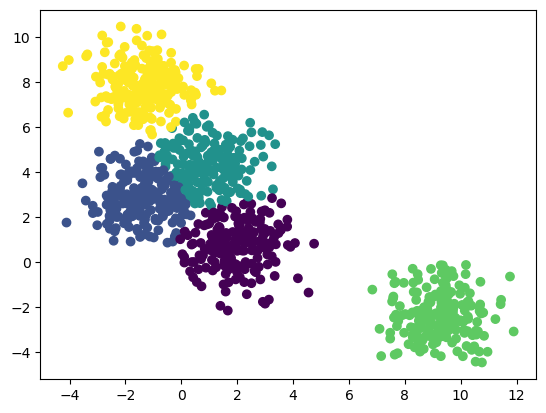

In [ ]:
start = time()
kkm.fit(x)
end = time()
print(end - start)
visualize(x, kkm.labels)

In [ ]:
x, l = make_circles(7000, factor = 0.4, random_state=0)

In [ ]:
kkm = KKMeans(n_clusters = 2, verbose = True, init = "kmeans++", kernel = "rbf", seed = 0, tol = 1e-4, variance=0.4, n_init = 5, q_metric="inertia", algorithm="lloyd")

Converged at iteration: 1 inertia: 5661.005505994073
Iteration: 1 inertia: 5784.662011156155
Iteration: 2 inertia: 5767.460826662198
Iteration: 3 inertia: 5759.2393058095095
Iteration: 4 inertia: 5750.70361841647
Iteration: 5 inertia: 5741.790134714787
Iteration: 6 inertia: 5732.256515618136
Iteration: 7 inertia: 5722.0163128715
Iteration: 8 inertia: 5710.96651599458
Iteration: 9 inertia: 5698.794230702577
Iteration: 10 inertia: 5685.128307401199
Iteration: 11 inertia: 5669.50953923946
Iteration: 12 inertia: 5651.575134306451
Iteration: 13 inertia: 5630.099221062976
Iteration: 14 inertia: 5603.364955370463
Iteration: 15 inertia: 5551.916298572699
Converged at iteration: 16 inertia: 5521.144117944171
Iteration: 1 inertia: 5776.649553919222
Iteration: 2 inertia: 5768.493305417622
Iteration: 3 inertia: 5760.264146791457
Iteration: 4 inertia: 5751.728308210113
Iteration: 5 inertia: 5742.822639542299
Iteration: 6 inertia: 5733.304047380167
Iteration: 7 inertia: 5723.086337689017
Iteration: 

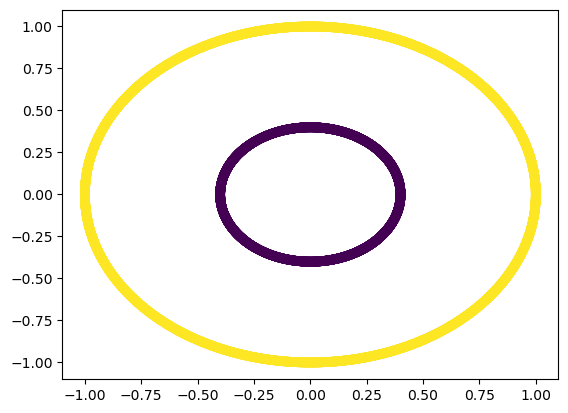

In [ ]:
start = time()
kkm.fit(x)
end = time()
print(end - start)
visualize(x, kkm.labels)

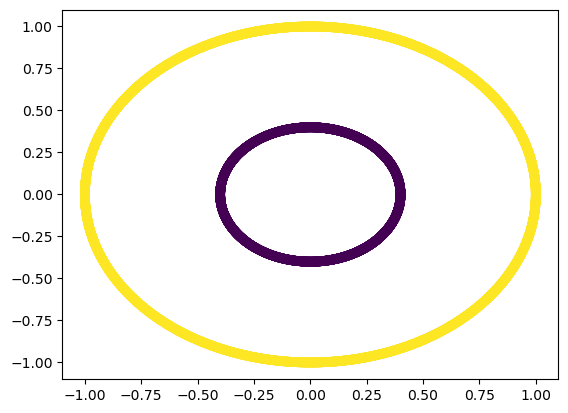

In [ ]:
visualize(x, kkm.predict(x))

In [ ]:
all(kkm.predict(x) == kkm.labels)

True

In [ ]:
n_c = 75
size = 10000
r_s = 0
x, labels, centers = make_blobs(size, centers=n_c, return_centers = True, random_state = r_s, n_features = 2)

In [ ]:
seed = 0
tol = 1e-4
inits= 3
initmethod = "kmeans++"
kkml =  KKMeans(n_clusters = n_c, verbose = True, init =initmethod, kernel = "linear", seed=seed, tol=tol, n_init=inits, q_metric="inertia", algorithm="lloyd")
kkme =  KKMeans(n_clusters = n_c, verbose = True, init =initmethod, kernel = "linear", seed=seed, tol=tol, n_init=inits, q_metric="inertia", algorithm="elkan")

Iteration: 1 inertia: 9994.54333998964
Iteration: 2 inertia: 9470.305115122383
Iteration: 3 inertia: 9216.514092908441
Iteration: 4 inertia: 9048.094353451641
Iteration: 5 inertia: 8905.997432296565
Iteration: 6 inertia: 8777.982564931914
Iteration: 7 inertia: 8685.556265360603
Iteration: 8 inertia: 8623.546891378517
Iteration: 9 inertia: 8566.208034410422
Iteration: 10 inertia: 8521.116643744783
Iteration: 11 inertia: 8486.11133207823
Iteration: 12 inertia: 8462.232737929442
Iteration: 13 inertia: 8446.286102031667
Iteration: 14 inertia: 8436.45582989384
Iteration: 15 inertia: 8428.69844496955
Iteration: 16 inertia: 8422.655432791158
Iteration: 17 inertia: 8418.254790653516
Iteration: 18 inertia: 8414.356629742077
Iteration: 19 inertia: 8410.273245167682
Iteration: 20 inertia: 8405.698957546369
Iteration: 21 inertia: 8399.509868975552
Iteration: 22 inertia: 8393.097778750074
Iteration: 23 inertia: 8382.880209664356
Iteration: 24 inertia: 8373.714894606594
Iteration: 25 inertia: 8367.4

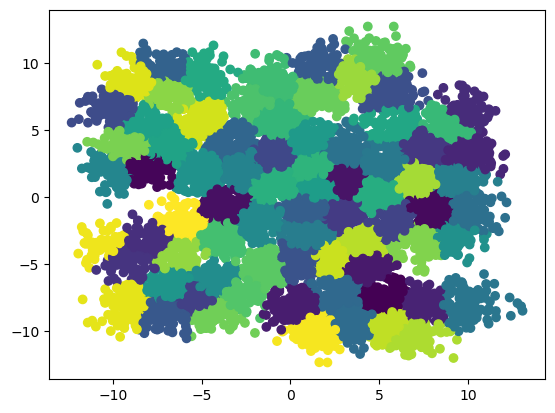

In [ ]:
start = time()
kkml.fit(x)
end = time()
print(end - start)
visualize(x, kkml.labels)

Iteration: 1 inertia: 9994.54333998964
Iteration: 2 inertia: 9470.305115122383
Iteration: 3 inertia: 9216.514092908441
Iteration: 4 inertia: 9048.094353451641
Iteration: 5 inertia: 8905.997432296565
Iteration: 6 inertia: 8777.982564931914
Iteration: 7 inertia: 8685.556265360603
Iteration: 8 inertia: 8623.546891378515
Iteration: 9 inertia: 8566.208034410422
Iteration: 10 inertia: 8521.116643744783
Iteration: 11 inertia: 8486.111332078231
Iteration: 12 inertia: 8462.232737929444
Iteration: 13 inertia: 8446.286102031667
Iteration: 14 inertia: 8436.455829893837
Iteration: 15 inertia: 8428.69844496955
Iteration: 16 inertia: 8422.655432791158
Iteration: 17 inertia: 8418.254790653516
Iteration: 18 inertia: 8414.356629742077
Iteration: 19 inertia: 8410.273245167682
Iteration: 20 inertia: 8405.698957546369
Iteration: 21 inertia: 8399.50986897555
Iteration: 22 inertia: 8393.097778750074
Iteration: 23 inertia: 8382.880209664356
Iteration: 24 inertia: 8373.714894606594
Iteration: 25 inertia: 8367.

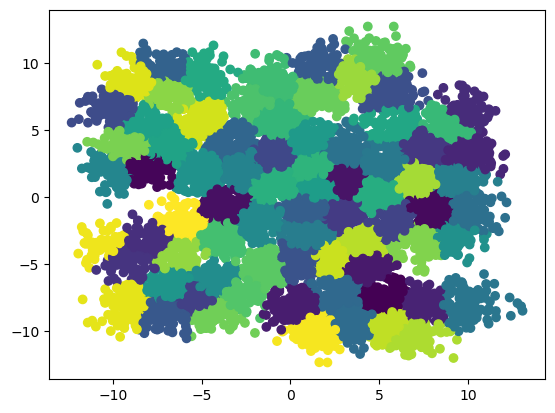

In [ ]:
start = time()
kkme.fit(x)
end = time()
print(end - start)
visualize(x, kkme.labels)

In [ ]:
print(all(kkme.labels == kkml.labels))

True


In [ ]:
iter = 100
elkan_store = []
lloyd_store = []

n_c = 100
size = 1000

tol = 1e-4
inits= 1
initmethod = "kmeans++"
verb = False
max_iter = 100

for i in range(iter):
    print(i)
    x, labels, centers = make_blobs(size, centers=n_c, return_centers = True, random_state = i, n_features = 2)

    kkml =  KKMeans(n_clusters = n_c, verbose=verb, init =initmethod, kernel = "linear", seed=i, tol=tol, n_init=inits, q_metric="inertia", algorithm="lloyd", max_iter=max_iter)
    kkme =  KKMeans(n_clusters = n_c, verbose=verb, init =initmethod, kernel = "linear", seed=i, tol=tol, n_init=inits, q_metric="inertia", algorithm="elkan", max_iter = max_iter)

    start = time()
    kkml.fit(x)
    end = time()
    lloyd_store.append(end - start)
    start = time()
    kkme.fit(x)
    end = time()
    elkan_store.append(end - start)
    assert(np.isclose(kkml.quality, kkme.quality))
    assert(all(kkml.labels == kkme.labels))

print(sum(elkan_store)/len(elkan_store))
print(sum(lloyd_store)/len(lloyd_store))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.03825841665267944
0.048469438552856445


In [ ]:
print(sum(elkan_store)/len(elkan_store))
print(sum(lloyd_store)/len(lloyd_store))

0.03825841665267944
0.048469438552856445


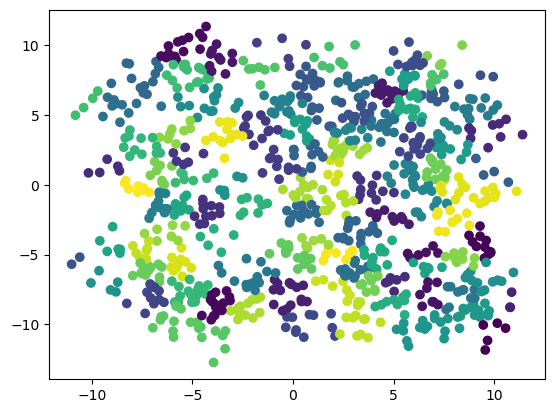

In [ ]:
visualize(x, kkml.labels)